# Iris Training and Prediction with Sagemaker Scikit-learn
### Modified Version of AWS Example:
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_iris/Scikit-learn%20Estimator%20Example%20With%20Batch%20Transform.ipynb  

Following modifications were made:  
1. Incorporated scripts for local mode hosting  
2. Added Train and Test Channels  
3. Visualize results (confusion matrix and reports)  
4. Added steps to deploy using model artifacts stored in S3  
  
Following Script changes were made:  
1. RandomForest Algorithm
2. Refactored script to follow the template provided in tensorflow example:
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb


This tutorial shows you how to use [Scikit-learn](https://scikit-learn.org/stable/) with Sagemaker by utilizing the pre-built container. Scikit-learn is a popular Python machine learning framework. It includes a number of different algorithms for classification, regression, clustering, dimensionality reduction, and data/feature pre-processing. 

The [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) module  makes it easy to take existing scikit-learn code, which we will show by training a model on the IRIS dataset and generating a set of predictions. For more information about the Scikit-learn container, see the [sagemaker-scikit-learn-containers](https://github.com/aws/sagemaker-scikit-learn-container) repository and the [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) repository.

For more on Scikit-learn, please visit the Scikit-learn website: <http://scikit-learn.org/stable/>.

### Table of contents
* [Upload the data for training](#upload_data)
* [Create a Scikit-learn script to train with](#create_sklearn_script)
* [Create the SageMaker Scikit Estimator](#create_sklearn_estimator)
* [Train the SKLearn Estimator on the Iris data](#train_sklearn)
* [Using the trained model to make inference requests](#inferece)
 * [Deploy the model](#deploy)
 * [Choose some data and use it for a prediction](#prediction_request)
 * [Endpoint cleanup](#endpoint_cleanup)
* [Batch Transform](#batch_transform)
 * [Prepare Input Data](#prepare_input_data)
 * [Run Transform Job](#run_transform_job)
 * [Check Output Data](#check_output_data)

First, lets create our Sagemaker session and role, and create a S3 prefix to use for the notebook example.

### Local Mode Execution - requires docker compose configured
### The below setup script is from AWS SageMaker Python SDK Examples : tf-eager-sm-scriptmode.ipynb

In [1]:
!/bin/bash ./setup.sh

SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [2]:
import os
import sys
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

import sklearn
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# SageMaker SKLearn Estimator
from sagemaker.sklearn.estimator import SKLearn

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [3]:
print('Python version', sys.version)
print ('Sklearn version', sklearn.__version__)

Python version 3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Sklearn version 0.24.1


## Training Data

In [4]:
column_list_file = 'iris_train_column_list.txt'
train_file = 'iris_train.csv'
test_file = 'iris_validation.csv'

columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [5]:
# Specify your bucket name
bucket_name = 'chandra-sagemaker'

training_folder = r'iris/train'
test_folder = r'iris/test'
model_folder = r'iris/model/'

training_data_uri = r's3://' + bucket_name + r'/' + training_folder
testing_data_uri = r's3://' + bucket_name + r'/' + test_folder
model_data_uri = r's3://' + bucket_name + r'/' + model_folder

In [6]:
training_data_uri,testing_data_uri,model_data_uri

('s3://chandra-sagemaker/iris/train',
 's3://chandra-sagemaker/iris/test',
 's3://chandra-sagemaker/iris/model/')

In [7]:
sagemaker_session.upload_data(train_file,
                              bucket=bucket_name, 
                              key_prefix=training_folder)

's3://chandra-sagemaker/iris/train/iris_train.csv'

In [8]:
sagemaker_session.upload_data(test_file, 
                              bucket=bucket_name, 
                              key_prefix=test_folder)

's3://chandra-sagemaker/iris/test/iris_validation.csv'

Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

## Create a Scikit-learn script to train with <a class="anchor" id="create_sklearn_script"></a>
SageMaker can now run a scikit-learn script using the `SKLearn` estimator. When executed on SageMaker a number of helpful environment variables are available to access properties of the training environment, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
* `SM_OUTPUT_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the `SKLearn` estimator's `fit()` method, the following environment variables will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: A string representing the path to the directory containing data in the 'train' channel
* `SM_CHANNEL_TEST`: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance. For example, the script that we will run in this notebook is the below:

In [9]:
!pygmentize 'scikit_learn_iris.py'

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#  
#      http://www.apache.org/licenses/LICENSE-2.0
#  
#  or in the "license" file accompanying this file. This file is distributed 
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either 
#  express or implied. See the License for the specific language governing 
#  permissions and limitations under the License.

from __future__ import print_function

import argparse
import os
import pandas as pd
import json

from sklearn import ensemble
# from sklearn.externals import joblib
# joblib is no longer part of sklearn.externals
# we can directly import it
import joblib


def model(args, x_train, y_train, x_test, y_test):   
    model = ensemble.RandomForestClassifier(n_estimators=args.n_estimators,max_depth=args.max_

Because the Scikit-learn container imports your training script, you should always put your training code in a main guard `(if __name__=='__main__':)` so that the container does not inadvertently run your training code at the wrong point in execution.

For more information about training environment variables, please visit https://github.com/aws/sagemaker-containers.

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [10]:
#instance_type='ml.m5.xlarge'

instance_type='local'

In [11]:
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html

# SDK 2.x version does not require train prefix for instance count and type
# Specify framework and python Version

# Updated framework version from 0.20.0 to 0.23-1

estimator = SKLearn(entry_point='scikit_learn_iris.py',
                    framework_version = "0.23-1",
                    py_version = 'py3',
                    instance_type= instance_type,                     
                    role=role, 
                    output_path=model_data_uri,
                    base_job_name='sklearn-iris',
                    hyperparameters={'n_estimators': 50,'max_depth':5})

## Train SKLearn Estimator on Iris data <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [12]:
estimator.fit({'training':training_data_uri,'testing':testing_data_uri})

Creating 26szagfn6b-algo-1-a9970 ... 
Creating 26szagfn6b-algo-1-a9970 ... done
Attaching to 26szagfn6b-algo-1-a9970
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:32,987 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:32,991 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:33,043 sagemaker_sklearn_container.training INFO     Invoking user training script.
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:33,231 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:33,245 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:33,258 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
26szagfn6b-algo-1-a9970 | 2023-07-12 18:31:33,268 sagemaker-training-toolkit INFO     In

===== Job Complete =====


In [13]:
estimator.latest_training_job.job_name

'sklearn-iris-2023-07-12-18-31-29-800'

In [14]:
estimator.model_data

's3://chandra-sagemaker/iris/model/sklearn-iris-2023-07-12-18-31-29-800/model.tar.gz'

## Using the trained model to make inference requests <a class="anchor" id="inference"></a>

### Deploy the model <a class="anchor" id="deploy"></a>

Deploying the model to SageMaker hosting just requires a `deploy` call on the fitted model. This call takes an instance count and instance type.

In [15]:
predictor = estimator.deploy(initial_instance_count=1, 
                           instance_type=instance_type)

Attaching to 3w9lq8o559-algo-1-0hmy8
3w9lq8o559-algo-1-0hmy8 | 2023-07-12 18:31:38,461 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
3w9lq8o559-algo-1-0hmy8 | 2023-07-12 18:31:38,465 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
3w9lq8o559-algo-1-0hmy8 | 2023-07-12 18:31:38,466 INFO - sagemaker-containers - nginx config: 
3w9lq8o559-algo-1-0hmy8 | worker_processes auto;
3w9lq8o559-algo-1-0hmy8 | daemon off;
3w9lq8o559-algo-1-0hmy8 | pid /tmp/nginx.pid;
3w9lq8o559-algo-1-0hmy8 | error_log  /dev/stderr;
3w9lq8o559-algo-1-0hmy8 | 
3w9lq8o559-algo-1-0hmy8 | worker_rlimit_nofile 4096;
3w9lq8o559-algo-1-0hmy8 | 
3w9lq8o559-algo-1-0hmy8 | events {
3w9lq8o559-algo-1-0hmy8 |   worker_connections 2048;
3w9lq8o559-algo-1-0hmy8 | }
3w9lq8o559-algo-1-0hmy8 | 
3w9lq8o559-algo-1-0hmy8 | http {
3w9lq8o559-algo-1-0hmy8 |   include /etc/nginx/mime.types;
3w9lq8o559-algo-1-0hmy8 |   default_type application/octet-stream;
3w9lq8o559-algo-1-0hmy

### Choose some data and use it for a prediction <a class="anchor" id="prediction_request"></a>

In order to do some predictions, we'll extract some of the data we used for training and do predictions against it. This is, of course, bad statistical practice, but a good way to see how the mechanism works.

In [16]:
df = pd.read_csv(test_file, names=columns)

In [17]:
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# Encode Class Labels to integers
# Labeled Classes
labels=[0,1,2]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [19]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [20]:
X_test = df.iloc[:,1:]
print(X_test[:5])

   sepal_length  sepal_width  petal_length  petal_width
0           5.8          2.7           4.1          1.0
1           4.8          3.4           1.6          0.2
2           6.0          2.2           4.0          1.0
3           6.4          3.1           5.5          1.8
4           6.7          2.5           5.8          1.8


In [21]:
result = predictor.predict(X_test)

3w9lq8o559-algo-1-0hmy8 | 172.18.0.1 - - [12/Jul/2023:18:31:47 +0000] "POST /invocations HTTP/1.1" 200 488 "-" "python-urllib3/1.26.8"


In [22]:
result

array([1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2,
       0, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0, 1, 2, 2,
       1])

In [23]:
df['predicted_class'] = result

In [24]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width,predicted_class
0,1,5.8,2.7,4.1,1.0,1
1,0,4.8,3.4,1.6,0.2,0
2,1,6.0,2.2,4.0,1.0,1
3,2,6.4,3.1,5.5,1.8,2
4,2,6.7,2.5,5.8,1.8,2


<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [25]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['encoded_class'],
                              df['predicted_class'],labels=labels)

In [27]:
cnf_matrix

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 17]])

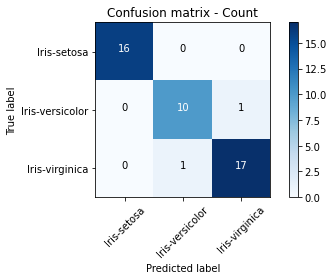

In [28]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

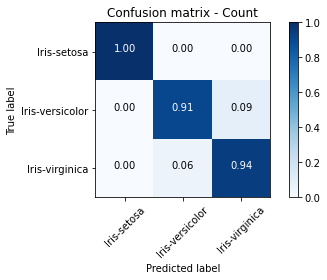

In [29]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)

In [30]:
print(classification_report(
    df['encoded_class'],
    df['predicted_class'],
    labels=labels,
    target_names=classes))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.91      0.91      0.91        11
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



### Endpoint cleanup <a class="anchor" id="endpoint_cleanup"></a>

When you're done with the endpoint, you'll want to clean it up.

In [31]:
# SDK 2
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


## Another way to deploy endpoint
## Using trained model artifacts
https://sagemaker.readthedocs.io/en/stable/sagemaker.sklearn.html#scikit-learn-predictor
https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#working-with-existing-model-data-and-training-jobs

In [32]:
model_data = estimator.model_data

In [33]:
model_data

's3://chandra-sagemaker/iris/model/sklearn-iris-2023-07-12-18-31-29-800/model.tar.gz'

In [34]:
# Updated framework version from 0.20.0 to 0.23-1
import sagemaker.sklearn

model = sagemaker.sklearn.model.SKLearnModel(model_data=model_data,
                                             role=role, entry_point='scikit_learn_iris.py',
                                             framework_version = "0.23-1",
                                             py_version = 'py3')

In [35]:
predictor_2 = model.deploy(initial_instance_count=1, instance_type=instance_type)

Attaching to pkfcbrprea-algo-1-jmnhz
pkfcbrprea-algo-1-jmnhz | 2023-07-12 18:31:51,453 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
pkfcbrprea-algo-1-jmnhz | 2023-07-12 18:31:51,457 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
pkfcbrprea-algo-1-jmnhz | 2023-07-12 18:31:51,458 INFO - sagemaker-containers - nginx config: 
pkfcbrprea-algo-1-jmnhz | worker_processes auto;
pkfcbrprea-algo-1-jmnhz | daemon off;
pkfcbrprea-algo-1-jmnhz | pid /tmp/nginx.pid;
pkfcbrprea-algo-1-jmnhz | error_log  /dev/stderr;
pkfcbrprea-algo-1-jmnhz | 
pkfcbrprea-algo-1-jmnhz | worker_rlimit_nofile 4096;
pkfcbrprea-algo-1-jmnhz | 
pkfcbrprea-algo-1-jmnhz | events {
pkfcbrprea-algo-1-jmnhz |   worker_connections 2048;
pkfcbrprea-algo-1-jmnhz | }
pkfcbrprea-algo-1-jmnhz | 
pkfcbrprea-algo-1-jmnhz | http {
pkfcbrprea-algo-1-jmnhz |   include /etc/nginx/mime.types;
pkfcbrprea-algo-1-jmnhz |   default_type application/octet-stream;
pkfcbrprea-algo-1-jmnh

In [36]:
predictor_2.predict(X_test[:5])

pkfcbrprea-algo-1-jmnhz | 2023-07-12 18:32:00,303 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)


array([1, 0, 1, 2, 2])

pkfcbrprea-algo-1-jmnhz | 172.18.0.1 - - [12/Jul/2023:18:32:00 +0000] "POST /invocations HTTP/1.1" 200 168 "-" "python-urllib3/1.26.8"


In [37]:
predictor_2.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
